# Hierarchical Inference of ∆F

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 


In [100]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import mut.viz
import mut.stats
colors = mut.viz.personal_style()
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In [90]:
data = pd.read_csv('../../data/csv/compiled_data.csv')
data.dropna(inplace=True)

In [152]:
%%stan -v hier_F

data {
    int<lower=1> N; // Total number of measurements
    int<lower=1> J; // Total number of unique samples.
    int<lower=1, upper=J> idx[N];  
    vector[N] obs_fc; // Observed fold-change in gene expression
}

parameters {
    vector<upper=0>[J] log_mu_fc; // Mean fold_change for each unique sample
    vector<upper=0>[J] log_sigma_fc; // Standard deviation for each sample
}

transformed parameters {
    vector[J] mu_fc = exp(log_mu_fc);
    vector[J] sigma_fc = exp(log_sigma_fc);
}
model {
    log_mu_fc ~ uniform(-8, 0);
    log_sigma_fc ~ normal(-2, 1);
    obs_fc ~ normal(mu_fc[idx], sigma_fc[idx]); 
}

generated quantities {
    vector[J] empirical_bohr = log((1 ./ mu_fc) - 1);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hier_F object.
Type hier_F in a cell to see a nicely formatted code output in a notebook
     ^^^^^^
Access model compile output properties
hier_F.model_file -> Name of stan_file [None]
hier_F.model_name -> Name of stan model [None]
hier_F.model_code -> Model code [ data {     int<lowe ....]


In [ ]:
model = pystan.StanModel(model_code=hier_F.model_code)

In [154]:
# Assign identififers. 
dfs = []
grouped = data.groupby(['class', 'mutant', 'repressors', 'operator', 'IPTGuM'])
_idx = 1
for g, d in grouped:
    d = d.copy()
    d['idx'] = _idx
    dfs.append(d)
    _idx += 1

_data = pd.concat(dfs, sort=False)
# Generate data dict
data_dict = {'N': len(_data), 
             'J':np.max(_data['idx']),
             'idx':_data['idx'].astype(int),
             'obs_fc': _data['fold_change']}

samples = model.sampling(data_dict, iter=5000, control=dict(adapt_delta=0.99))

Text(0, 0.5, 'sigma')

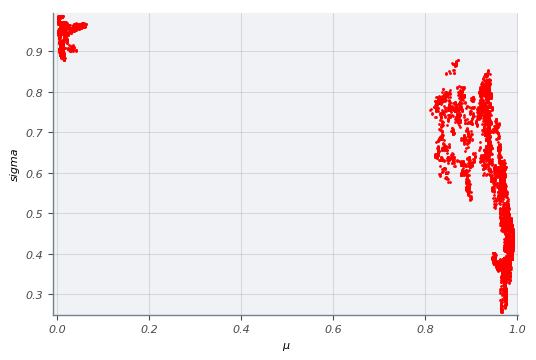

In [155]:
samples_df = samples.to_dataframe()
fig, ax = plt.subplots()
for g, d in samples_df.groupby(['divergent__']):
    if g == 0:
        color = 'k'
    else:
        color = 'r'
    ax.plot(d['mu_fc[8]'], d['sigma_fc[10]'], '.', ms=2, color=color)
    
ax.set_xlabel('µ')
ax.set_ylabel('sigma')

In [156]:
stat_df = pd.DataFrame()
ind = np.argmax(samples_df['lp__'].values)
mode_loc = samples_df.iloc[ind]
for g, d in _data.groupby('idx'):
    fc_hpd = mut.stats.compute_hpd(samples_df[f'mu_fc[{g}]'], 0.95)
    sig_hpd = mut.stats.compute_hpd(samples_df[f'sigma_fc[{g}]'], 0.95)
    bohr_hpd = mut.stats.compute_hpd(samples_df[f'empirical_bohr[{g}]'], 0.95)
    _mapper = {'repressors':d['repressors'].unique()[0],
              'mutant': d['mutant'].unique()[0],
              'operator':d['operator'].unique()[0],
              'IPTGuM': d['IPTGuM'].unique()[0],
              'class': d['class'].unique()[0],
              'fc_mu_mode': mode_loc[f'mu_fc[{g}]'],
              'fc_mu_min': fc_hpd[0],
              'fc_mu_max': fc_hpd[1],
              'sigma_fc_mode': mode_loc[f'sigma_fc[{g}]'],
              'sigma_fc_min': sig_hpd[0],
              'sigma_fc_max': sig_hpd[1],
              'empirical_F': mode_loc[f'empirical_bohr[{g}]'],
              'empirical_F_min': bohr_hpd[0],
              'empirical_F_max': bohr_hpd[1]}  
    stat_df = stat_df.append(_mapper, ignore_index=True)

In [157]:
stat_df.to_csv('../../data/csv/hierarchical_F_foldchange_stats.csv', index=False)

## Exploring the results

In [158]:
DNA_muts = stat_df[(stat_df['class']=='DNA') &
                   (stat_df['repressors']==260) &
                   (stat_df['operator']=='O2')]

(-0.15, 1.15)

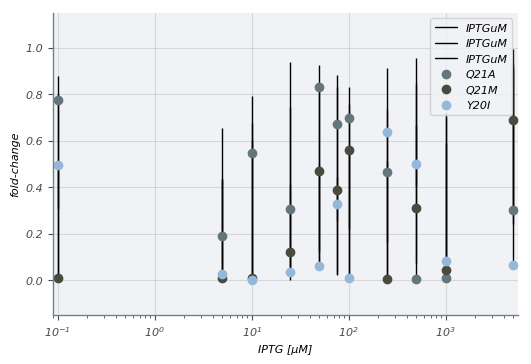

In [159]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('IPTG [µM]')
ax.set_ylabel('fold-change')

for g, d in DNA_muts.groupby(['mutant']):
    ax.errorbar(d['IPTGuM'], d['fc_mu_mode'], fmt='o', lw=1, linestyle='none', label=g)
    ax.vlines(d['IPTGuM'], d['fc_mu_min'], d['fc_mu_max'], lw=1)
ax.legend()

ax.set_ylim([-0.15, 1.15])

In [160]:
import mut.thermo
constants = mut.thermo.load_constants()

In [161]:
bohr = mut.thermo.SimpleRepression(R=260, ep_r=-13.9, effector_conc=DNA_muts['IPTGuM'],
                                  ka=constants['Ka'], ki=constants['Ki'], n_sites=constants['n_sites'],
                                  ep_ai=constants['ep_AI']).bohr_parameter()

DNA_muts['delta_F_mode'] = -bohr - DNA_muts['empirical_F']
DNA_muts['delta_F_min'] = -bohr - DNA_muts['empirical_F_min']
DNA_muts['delta_F_max'] = -bohr - DNA_muts['empirical_F_max']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

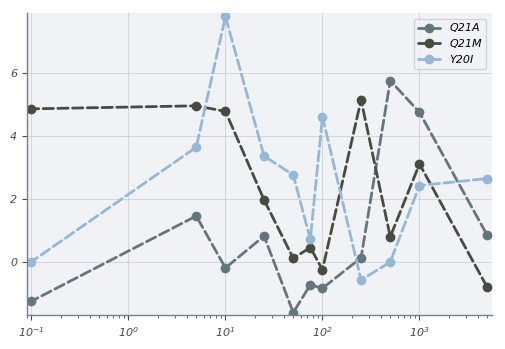

In [162]:
for g, d in DNA_muts.groupby(['mutant']):
    plt.semilogx(d['IPTGuM'], d['empirical_F'], '--o', label=g)
    

plt.legend()